In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [3]:
# Data paths - update these to match your directory structure
base_path = 'data'
train_path = f"{base_path}/train"
valid_path = f"{base_path}/valid"
test_path = f"{base_path}/test"
train_annotations = f"{train_path}/_annotations.csv"
valid_annotations = f"{valid_path}/_annotations.csv"
test_annotations = f"{test_path}/_annotations.csv"

# Image parameters
img_height = 224
img_width = 224
batch_size = 32

In [4]:
# Data preprocessing function
def load_and_preprocess_data(data_path, annotations_path):
    # Read annotations
    df = pd.read_csv(annotations_path)
    
    x_data = []
    y_data = []
    
    for i in tqdm(range(len(df))):
        try:
            # Read and convert image
            img_path = f"{data_path}/{df['filename'][i]}"
            if not os.path.exists(img_path):
                print(f"Warning: Image not found: {img_path}")
                continue
                
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image: {img_path}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Get bounding box coordinates
            ymin, ymax = max(0, df['ymin'][i]), min(img.shape[0], df['ymax'][i])
            xmin, xmax = max(0, df['xmin'][i]), min(img.shape[1], df['xmax'][i])
            
            # Crop the hieroglyph using bounding box coordinates
            img = img[ymin:ymax, xmin:xmax]
            
            # Resize to standard size
            img = cv2.resize(img, (img_height, img_width))
            
            # Normalize pixel values
            img = img / 255.0
            
            x_data.append(img)
            y_data.append(df['class'][i])
            
        except Exception as e:
            print(f"Error processing image {df['filename'][i]}: {str(e)}")
            continue
    
    return np.array(x_data), np.array(y_data)

# Function to visualize some samples
def visualize_samples(x_data, y_data, title):
    plt.figure(figsize=(15, 15))
    for i in range(min(16, len(x_data))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(x_data[i])
        plt.title(y_data[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

Loading training data...


100%|██████████| 2723/2723 [00:25<00:00, 105.40it/s]


Loading validation data...


100%|██████████| 778/778 [00:06<00:00, 114.72it/s]


Loading test data...


100%|██████████| 389/389 [00:03<00:00, 116.24it/s]


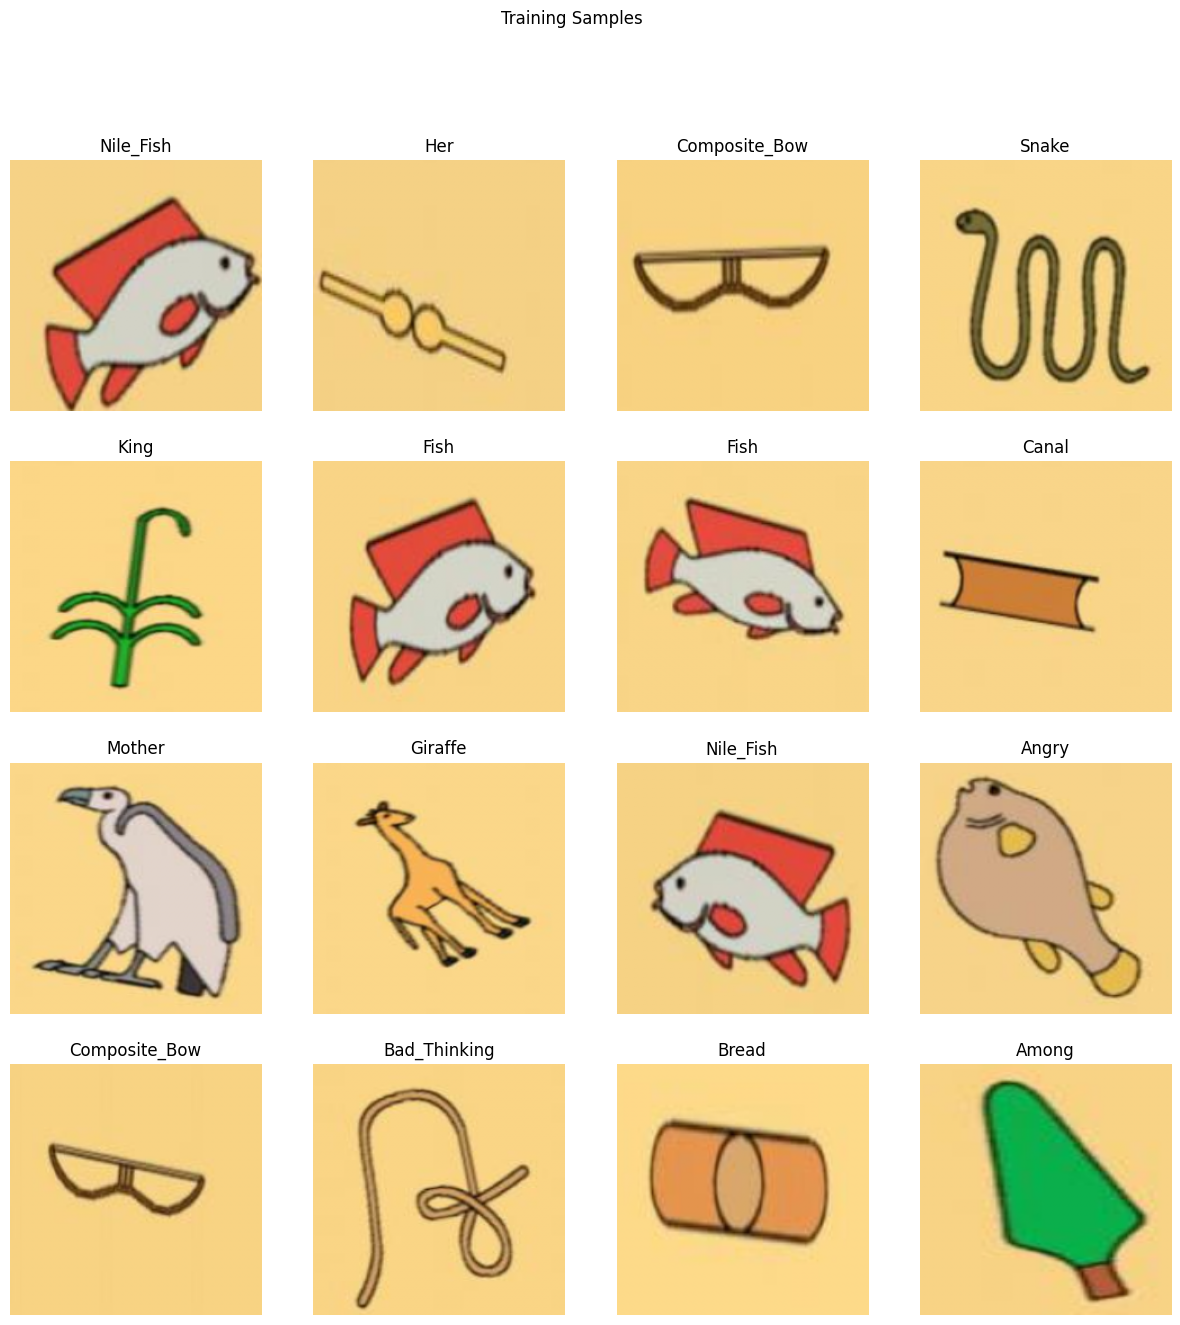

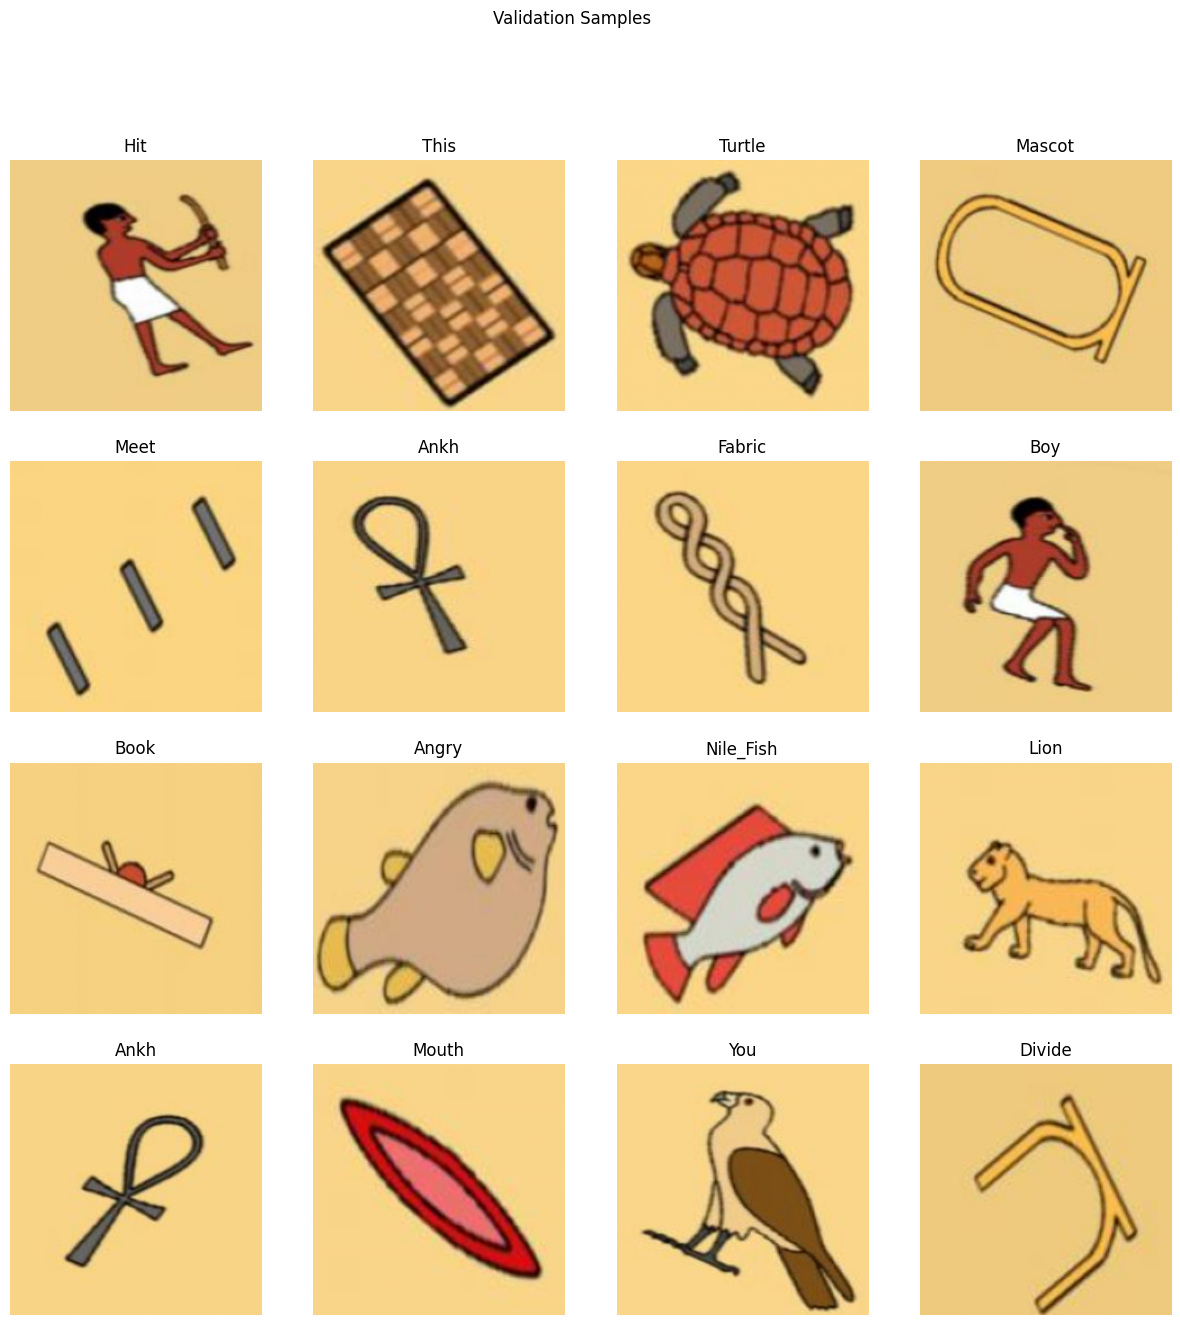

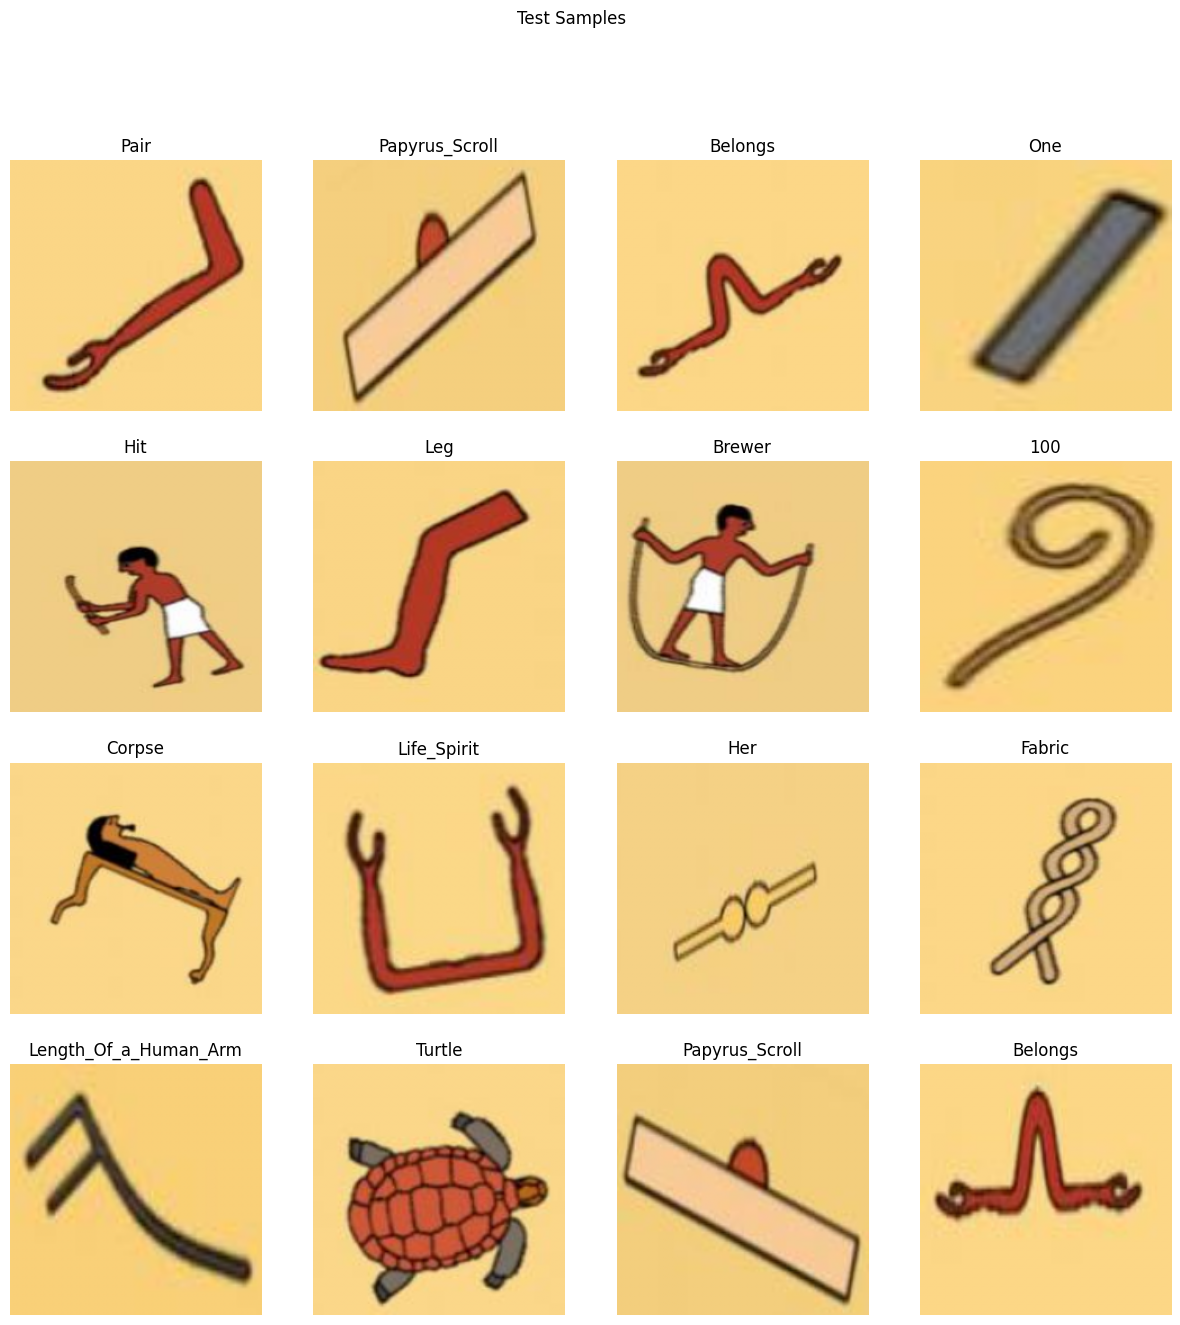


Dataset Information:
Training samples: 2723
Validation samples: 778
Test samples: 389
Image shape: (224, 224, 3)
Number of classes: 95
Classes: ['100' 'Among' 'Angry' 'Ankh' 'Aroura' 'At' 'Bad_Thinking' 'Bandage' 'Bee'
 'Belongs' 'Birth' 'Board_Game' 'Book' 'Boy' 'Branch' 'Bread' 'Brewer'
 'Builder' 'Bury' 'Canal' 'Cloth_on_Pole' 'Cobra' 'Composite_Bow' 'Cooked'
 'Corpse' 'Dessert' 'Divide' 'Duck' 'Elephant' 'Enclosed_Mound' 'Eye'
 'Fabric' 'Face' 'Falcon' 'Fingre' 'Fish' 'Flail' 'Folded_Cloth' 'Foot'
 'Galena' 'Giraffe' 'He' 'Her' 'Hit' 'Horn' 'King' 'Leg'
 'Length_Of_a_Human_Arm' 'Life_Spirit' 'Limit' 'Lion' 'Lizard' 'Loaf'
 'Loaf_Of_Bread' 'Man' 'Mascot' 'Meet' 'Mother' 'Mouth'
 'Musical_Instrument' 'Nile_Fish' 'Not' 'Now' 'Nurse' 'Nursing' 'Occur'
 'One' 'Owl' 'Pair' 'Papyrus_Scroll' 'Pool' 'QuailChick' 'Reed' 'Ring'
 'Rope' 'Ruler' 'Sail' 'Sandal' 'Semen' 'Small_Ring' 'Snake' 'Soldier'
 'Star' 'Stick' 'Swallow' 'This' 'To_Be_Dead' 'To_Protect' 'To_Say'
 'Turtle' 'Viper' 'Wall' 'W

In [5]:
# Load the data
print("Loading training data...")
x_train, y_train = load_and_preprocess_data(train_path, train_annotations)
print("Loading validation data...")
x_valid, y_valid = load_and_preprocess_data(valid_path, valid_annotations)
print("Loading test data...")
x_test, y_test = load_and_preprocess_data(test_path, test_annotations)

# Visualize samples from each set
visualize_samples(x_train, y_train, "Training Samples")
visualize_samples(x_valid, y_valid, "Validation Samples")
visualize_samples(x_test, y_test, "Test Samples")

# Print dataset information
print("\nDataset Information:")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_valid)}")
print(f"Test samples: {len(x_test)}")
print(f"Image shape: {x_train[0].shape}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
num_classes = len(label_encoder.classes_)

# Convert integers to one-hot encoding manually
def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

y_train = to_categorical(label_encoder.fit_transform(y_train), num_classes)
y_valid = to_categorical(label_encoder.transform(y_valid), num_classes)
y_test = to_categorical(label_encoder.transform(y_test), num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

In [6]:
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

In [8]:
def create_simple_cnn():
    model = Sequential([
        Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D(),
        
        Conv2D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        
        Conv2D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, 
                         input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def create_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, 
                               input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def create_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, 
                            input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def create_dense_net():
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, 
                            input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [9]:
def train_and_evaluate_model(model, model_name):
    try:
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )
        
        print(f"\nTraining {model_name}:")
        print(f"Input shape: {model.input_shape}")
        print(f"Output shape: {model.output_shape}")
        
        history = model.fit(
            x_train, y_train,
            validation_data=(x_valid, y_valid),
            batch_size=batch_size,
            epochs=20,
            callbacks=callbacks,
            verbose=1
        )
        
        last_epoch = history.history
        train_acc = last_epoch['accuracy'][-1]
        train_precision = last_epoch['precision'][-1]
        train_recall = last_epoch['recall'][-1]
        
        test_results = model.evaluate(
            x_test, y_test,
            verbose=1
        )
        
        test_acc = test_results[1]
        test_precision = test_results[2]
        test_recall = test_results[3]
        
        return {
            'model': model_name,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_precision': train_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'test_recall': test_recall
        }
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        return None

In [11]:
models = {
    'Simple CNN': create_simple_cnn(),
    'ResNet50': create_resnet50(),
    'EfficientNetB0': create_efficientnet(),
    'MobileNetV2': create_mobilenet()
}

results = []
for name, model in models.items():
    print(f"Training {name}...")
    result = train_and_evaluate_model(model, name)
    results.append(result)
    # Save model
    model.save(f'{name}_hieroglyphs.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Simple CNN...

Training Simple CNN:
Input shape: (None, 224, 224, 3)
Output shape: (None, 95)
Epoch 1/20


I0000 00:00:1730029346.933239     110 service.cc:145] XLA service 0x7ec504007cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730029346.933335     110 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/86 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0435 - loss: 5.5245 - precision: 0.3550 - recall: 0.0173   

I0000 00:00:1730029353.744915     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.2271 - loss: 3.6370 - precision: 0.5515 - recall: 0.0906 - val_accuracy: 0.0077 - val_loss: 5.6875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8382 - loss: 0.7176 - precision: 0.9333 - recall: 0.6591 - val_accuracy: 0.0090 - val_loss: 6.3812 - val_precision: 0.0909 - val_recall: 0.0013 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9379 - loss: 0.3534 - precision: 0.9737 - recall: 0.8409 - val_accuracy: 0.0257 - val_loss: 6.1110 - val_precision: 0.0737 - val_recall: 0.0206 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9767 - loss: 0.1361 - precision: 0.9853 - recall: 0.9586 - val_accuracy: 0.0386 - val_loss: 5.9317 - val_precision: 0.0776 - val_recall: 0.0360 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9880

I0000 00:00:1730029494.746066     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.3453 - loss: 3.1240 - precision: 0.6567 - recall: 0.2061

I0000 00:00:1730029530.438739     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 456 bytes spill stores, 456 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 105s 520ms/step - accuracy: 0.3478 - loss: 3.1100 - precision: 0.6588 - recall: 0.2084 - val_accuracy: 0.0167 - val_loss: 13.5176 - val_precision: 0.0167 - val_recall: 0.0167 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.8881 - loss: 0.4566 - precision: 0.9298 - recall: 0.8046 - val_accuracy: 0.0103 - val_loss: 26.4482 - val_precision: 0.0103 - val_recall: 0.0103 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.9398 - loss: 0.2628 - precision: 0.9611 - recall: 0.9071 - val_accuracy: 0.0167 - val_loss: 16.6844 - val_precision: 0.0167 - val_recall: 0.0167 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.9689 - loss: 0.1102 - precision: 0.9749 - recall: 0.9659 - val_accuracy: 0.0167 - val_loss: 9.0739 - val_precision: 0.0606 - val_recall: 0.0026 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.

I0000 00:00:1730029818.707810     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_288', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_286', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 153s 827ms/step - accuracy: 0.5273 - loss: 2.3503 - precision: 0.7839 - recall: 0.4215 - val_accuracy: 0.0141 - val_loss: 4.6190 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9580 - loss: 0.1734 - precision: 0.9636 - recall: 0.9397 - val_accuracy: 0.0116 - val_loss: 4.8287 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9678 - loss: 0.1179 - precision: 0.9748 - recall: 0.9572 - val_accuracy: 0.0167 - val_loss: 5.1112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9630 - loss: 0.1477 - precision: 0.9671 - recall: 0.9479 - val_accuracy: 0.0219 - val_loss: 5.0398 - val_precision: 0.9231 - val_recall: 0.0154 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 127m

I0000 00:00:1730030118.929190     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 484 bytes spill stores, 484 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 56 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 288 bytes spill stores, 288 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 369ms/step - accuracy: 0.4533 - loss: 2.5482 - precision: 0.7528 - recall: 0.3324 - val_accuracy: 0.0090 - val_loss: 11.6534 - val_precision: 0.0093 - val_recall: 0.0090 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9191 - loss: 0.3301 - precision: 0.9422 - recall: 0.8721 - val_accuracy: 0.0231 - val_loss: 11.6047 - val_precision: 0.0249 - val_recall: 0.0231 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9229 - loss: 0.2700 - precision: 0.9510 - recall: 0.8871 - val_accuracy: 0.1221 - val_loss: 7.1464 - val_precision: 0.1445 - val_recall: 0.0964 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9428 - loss: 0.2095 - precision: 0.9599 - recall: 0.9175 - val_accuracy: 0.2134 - val_loss: 5.3210 - val_precision: 0.3048 - val_recall: 0.1787 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9664 - los

In [13]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
results_df


Model Comparison:


,model,train_acc,test_acc,train_precision,test_precision,train_recall,test_recall
0,Simple CNN,0.999265,0.958869,0.999633,0.973333,0.999265,0.938303
1,ResNet50,0.993390,0.002571,0.993748,0.002571,0.992288,0.002571
2,EfficientNetB0,0.991553,0.951157,0.991915,0.951157,0.991186,0.951157
3,MobileNetV2,0.978333,0.002571,0.980819,0.002674,0.976497,0.002571


In [11]:
# load densenet
model = create_dense_net()
name = 'DenseNet121'
results = []

print(f"Training {name}...")
result = train_and_evaluate_model(model, name)
results.append(result)
# Save model
model.save(f'{name}_hieroglyphs.keras')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training DenseNet121...

Training DenseNet121:
Input shape: (None, 224, 224, 3)
Output shape: (None, 95)
Epoch 1/20


I0000 00:00:1730039766.378732     119 service.cc:145] XLA service 0x794da8005590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730039766.378785     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730039860.628611     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3962 - loss: 2.9811 - precision: 0.7115 - recall: 0.2336

I0000 00:00:1730039968.988025     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_12', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_1', 640 bytes spill stores, 628 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_112', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_115', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_116', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_119', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_120', 8 bytes spill

86/86 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.4020 - loss: 2.9499 - precision: 0.7160 - recall: 0.2396 - val_accuracy: 0.3689 - val_loss: 2.5871 - val_precision: 0.5904 - val_recall: 0.1889 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.9362 - loss: 0.3193 - precision: 0.9547 - recall: 0.8744 - val_accuracy: 0.8573 - val_loss: 0.6122 - val_precision: 0.9319 - val_recall: 0.7031 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.9453 - loss: 0.2371 - precision: 0.9577 - recall: 0.9225 - val_accuracy: 0.9062 - val_loss: 0.3485 - val_precision: 0.9356 - val_recall: 0.8779 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.9327 - loss: 0.2703 - precision: 0.9586 - recall: 0.8893 - val_accuracy: 0.8085 - val_loss: 0.6362 - val_precision: 0.8765 - val_recall: 0.7481 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.9739 -

In [12]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
results_df


Model Comparison:


,model,train_acc,test_acc,train_precision,test_precision,train_recall,test_recall
0,DenseNet121,0.993022,0.989717,0.993015,0.989717,0.991921,0.989717
